<a href="https://colab.research.google.com/github/frex1/Time-Series/blob/master/lstm_beijing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Pollution Forecasting
Using Air Quality dataset from UCI.
This dataset contains hourly weather report and pollution levels at the US embassy, Beijing China for 5 years (2010-2014).
The pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain were recorded as follows:
*   No: row number
*   year: year of data in this row
*   month: month of data in this row
*   day: day of data in this row
*   hour: hour of data in this row
*   pm2.5: PM2.5 concentration
*   DEWP: Dew Point
*   TEMP: Temperature
*   PRES: Pressure
*   cbwd: Combined wind direction
*   Iws: Cumulated wind speed
*   Is: Cumulated hours of snow
*   Ir: Cumulated hours of rain

In [0]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Get and prepare data
We shall be using the UCI dataset. As part of the data preparation, we have to combine the year, month, day and hour into one datatime variable and use it as index. We shall also handle missing values if any and rename the variables with more sensible names.

In [14]:
# Read data and combine year, month, day, time into a datetime variable so it can be used as index. Name the index 'date'.
import pandas as pd
from datetime import datetime as dt
def parse(x):
	return dt.strptime(x, '%Y %m %d %H')
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
raw_data = pd.read_csv(url,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# Rename index
raw_data.index.name = 'date'
raw_data.head(5)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [9]:
# Check content
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   pm2.5   41757 non-null  float64
 2   DEWP    43824 non-null  int64  
 3   TEMP    43824 non-null  float64
 4   PRES    43824 non-null  float64
 5   cbwd    43824 non-null  object 
 6   Iws     43824 non-null  float64
 7   Is      43824 non-null  int64  
 8   Ir      43824 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.3+ MB


In [10]:
# Check for missing values
raw_data.isnull().sum()

No          0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [11]:
# dimension
raw_data.shape

(43824, 9)

In [95]:
# Drop missing values
chosen_data = raw_data.dropna(axis=0, how='any', inplace=False)
# Drop 'No' column
chosen_data.drop('No', inplace=True, axis=1)
# Rename the columns for clarity
chosen_data.columns = ['pollution', 'dew', 'temperature', 'pressure', 'wind_dir', 'wind_speed', 'snow', 'rain']
chosen_data.head(5)

,pollution,dew,temperature,pressure,wind_dir,wind_speed,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# Visualizations
Showing plot of each series

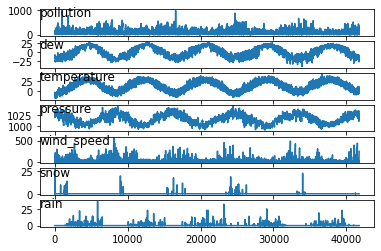

In [16]:
import matplotlib.pyplot as plt
values = chosen_data.values
# Select the variables to plot
series = [0,1, 2, 3, 5, 6, 7]
i = 1
# make seperate plots for each column
plt.figure()
for var in series:
	plt.subplot(len(series), 1, i)
	plt.plot(values[:, var])
	plt.title(chosen_data.columns[var], y=0.5, loc='left')
	i += 1
plt.show()

# Modelling
We can build an LSTM model using Keras with Tensorflow backend to predict the current pollution levels given previous polution and weather values. To do that we must prepare the data further by encoding the categorical variable, normalizing all input and then framing the series as a supervised learning problem.

In [17]:
# Import relevant libraries
from math import sqrt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [0]:
# Unique values of wind direction
chosen_data['wind_dir'].value_counts()

SE    14573
NW    13484
cv     8944
NE     4756
Name: wind_dir, dtype: int64

In [96]:
# Encode wind_dir values
encoder = LabelEncoder()
chosen_data['wind_dir'] = encoder.fit_transform(chosen_data['wind_dir'])
chosen_data['wind_dir'].value_counts()

2    14573
1    13484
3     8944
0     4756
Name: wind_dir, dtype: int64

In [0]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(chosen_data)

In [0]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# putting it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
# frame as supervised learning
reframed_data = series_to_supervised(scaled_data, 1, 1)
reframed_data.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011840,0.111111,0.0


In [26]:
# We are trying to predict pollution so let's drop the columns we are not interested in  predicting
reframed_data.drop(reframed_data.columns[[9,10,11,12,13,14,15]], axis = 1, inplace = True)
reframed_data.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658


We have used label encoding and 1 hour time steps but we could also try one hot encoding and more than 1 hr time steps considering LSTM's backpropagation

# Train Test split
Split the dataset into train and test sets, then split the train and test sets into input and output variables. The inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features]

In [84]:
# Split first 4 years as Train and last one year as Test
n_train_hours = 365 * 24
values = reframed_data.values
train = values[n_train_hours:,:]
test = values[:n_train_hours,:]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32996, 1, 8) (32996,) (8760, 1, 8) (8760,)


# Model
We are going to build an LSTM model with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We shall be using the Mean Absolute Error (MAE) as loss function and Adam version of stochastic gradient descent as optimizer. 50 training epochs will be used to fit the model with a batch size of 72.
The internal state of LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (to try).

We will set validation_data argument in the fit() function and plot to keep track of training and testing loss during training.

Train on 32996 samples, validate on 8760 samples
Epoch 1/50
 - 1s - loss: 0.0340 - val_loss: 0.0303
Epoch 2/50
 - 1s - loss: 0.0138 - val_loss: 0.0197
Epoch 3/50
 - 1s - loss: 0.0131 - val_loss: 0.0181
Epoch 4/50
 - 1s - loss: 0.0131 - val_loss: 0.0187
Epoch 5/50
 - 1s - loss: 0.0131 - val_loss: 0.0186
Epoch 6/50
 - 1s - loss: 0.0131 - val_loss: 0.0184
Epoch 7/50
 - 1s - loss: 0.0131 - val_loss: 0.0180
Epoch 8/50
 - 1s - loss: 0.0131 - val_loss: 0.0180
Epoch 9/50
 - 1s - loss: 0.0131 - val_loss: 0.0175
Epoch 10/50
 - 1s - loss: 0.0130 - val_loss: 0.0174
Epoch 11/50
 - 1s - loss: 0.0130 - val_loss: 0.0176
Epoch 12/50
 - 1s - loss: 0.0130 - val_loss: 0.0174
Epoch 13/50
 - 1s - loss: 0.0130 - val_loss: 0.0172
Epoch 14/50
 - 1s - loss: 0.0130 - val_loss: 0.0172
Epoch 15/50
 - 1s - loss: 0.0130 - val_loss: 0.0170
Epoch 16/50
 - 1s - loss: 0.0130 - val_loss: 0.0171
Epoch 17/50
 - 1s - loss: 0.0130 - val_loss: 0.0169
Epoch 18/50
 - 1s - loss: 0.0130 - val_loss: 0.0172
Epoch 19/50
 - 1s - loss

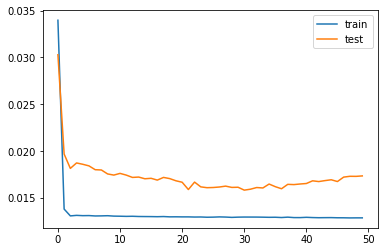

In [85]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Model evaluation
We will forecast for the entire test dataset then combine the forecast with the test dataset and invert the scaling. Invert scaling on the test dataset with the expected pollution numbers is also required.
Now that we have the forecasts and actual values in their original scales, we can evaluate the model. We shall use the Root Mean Squared Error (RMSE) that gives error in the same units.

In [86]:
# make predictions
y_pred = model.predict(X_test)
y_pred.shape

(8760, 1)

In [87]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
X_test.shape

(8760, 8)

In [88]:
print(X_test)

[[0.12977867 0.35294118 0.24590164 ... 0.00237151 0.         0.        ]
 [0.14889336 0.36764706 0.24590164 ... 0.00394662 0.         0.        ]
 [0.15995976 0.42647059 0.2295082  ... 0.00552173 0.         0.        ]
 ...
 [0.02414487 0.29411765 0.40983607 ... 0.10439969 0.         0.        ]
 [0.04627767 0.29411765 0.37704918 ... 0.11310704 0.         0.        ]
 [0.06136821 0.27941176 0.37704918 ... 0.12022158 0.         0.        ]]


In [89]:
print(y_pred)

[[0.13216259]
 [0.1513645 ]
 [0.16454656]
 ...
 [0.024085  ]
 [0.04490561]
 [0.05884916]]


In [0]:
# replace the pollution values with the predicted values to get the broadcast shape to inverse transform
y_pred=np.concatenate((y_pred, X_test[:,1:]), axis =1)

In [0]:
# inverse transform predicted
inv_y_pred = scaler.inverse_transform(y_pred)
inv_y_pred = inv_y_pred[:,0]

In [0]:
# inverse transform actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]

In [93]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 29.726
